# Overview do 3W Dataset proposto por Vargas (2019)

**_Referências_**
  
- **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** ([link](https://doi.org/10.1016/j.petrol.2019.106223)).
- **Github de referência** ([link](https://github.com/ricardovvargas/3w_dataset)).

## 1. Introdução

Este notebook apresenta uma visão geral do 3W Dataset proposto por Vargas (2019). São apresentadas algumas tabelas, gráficos e estatísticas.

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

## 2. Bibliotecas e configurações

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from datetime import datetime
from matplotlib.patches import Patch
from pathlib import Path
from multiprocessing.dummy import Pool as ThreadPool
from collections import defaultdict
from natsort import natsorted

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
data_path = Path('./', 'data')
events_names = {0: 'Normal',
                1: 'Aumento Abrupto de BSW',
                2: 'Fechamento Espúrio de DHSV',
                3: 'Intermitência Severa',
                4: 'Instabilidade de Fluxo',
                5: 'Perda Rápida de Produtividade',
                6: 'Restrição Rápida em CKP',
                7: 'Incrustação em CKP',
                8: 'Hidrato em Linha de Produção'
               }
columns = ['P-PDG',
           'P-TPT',
           'T-TPT',
           'P-MON-CKP',
           'T-JUS-CKP',
           'P-JUS-CKGL',
           'T-JUS-CKGL',
           'QGL',
           'class']

## 3. Quantidade de Instâncias

A tabela a seguir mostra as quantidades de instâncias que compõem o dataset, por tipo de evento e por fonte: instâncias reais, simuladas e desenhadas à mão.

In [5]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [6]:
# Carrega instâncias por fonte da instância (real, simulada ou desenhada)
real_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))
simulated_instances = list(class_and_file_generator(data_path, real=False, simulated=True, drawn=False))
drawn_instances = list(class_and_file_generator(data_path, real=False, simulated=False, drawn=True))

# Exemplo de saida da variavel real_instances:
#[(0, WindowsPath('data/0/WELL-00001_20170201020207.csv')),
# (0, WindowsPath('data/0/WELL-00001_20170201070114.csv')),
# ...]

# Dataframe das instância tipo de evento (código e nome) e fonte da instância.
df_class = pd.DataFrame([{'TIPO DE EVENTO': str(c) + ' - ' + events_names[c], 'FONTE': 'REAL'} for c, p in real_instances] + \
                  [{'TIPO DE EVENTO': str(c) + ' - ' + events_names[c], 'FONTE': 'SIMULATED'} for c, p in simulated_instances] + \
                  [{'TIPO DE EVENTO': str(c) + ' - ' + events_names[c], 'FONTE': 'DRAWN'} for c, p in drawn_instances])

# Agrupamento do dataframe por tipo e fonte com inclusão dos totais
df_class_count = df_class.groupby(['TIPO DE EVENTO', 'FONTE']).size().reset_index().pivot('FONTE', 'TIPO DE EVENTO', 0).fillna(0).astype(int).T
df_class_count = df_class_count.loc[natsorted(df_class_count.index.values)]
df_class_count = df_class_count[['REAL', 'SIMULATED', 'DRAWN']]
df_class_count['TOTAL'] = df_class_count.sum(axis=1)
df_class_count.loc['TOTAL'] = df_class_count.sum(axis=0)
df_class_count

FONTE,REAL,SIMULATED,DRAWN,TOTAL
TIPO DE EVENTO,,,,
0 - Normal,597,0,0,597
1 - Aumento Abrupto de BSW,5,114,10,129
2 - Fechamento Espúrio de DHSV,22,16,0,38
3 - Intermitência Severa,32,74,0,106
4 - Instabilidade de Fluxo,344,0,0,344
5 - Perda Rápida de Produtividade,12,439,0,451
6 - Restrição Rápida em CKP,6,215,0,221
7 - Incrustação em CKP,4,0,10,14
8 - Hidrato em Linha de Produção,3,81,0,84


# 4. Mapa de Dispersão das Instâncias Reais

Um mapa de dispersão com todas as **instâncias reais** é mostrado abaixo. O mais antigo ocorreu em meados de 2012 e o mais recente em meados de 2018. Além do número total de poços considerados, este mapa fornece uma visão geral das distribuições de ocorrências de cada evento indesejável ao longo do tempo e entre os poços.

In [7]:
def load_instance(instance):
    """Função que carrega cada instância individualmente"""
    class_code, instance_path = instance
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        assert (df.columns == columns).all(), f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        df['class_code'] = class_code
        df['well'] = well
        df['instance_id'] = instance_id
        df = df[['class_code', 'well', 'instance_id'] + columns]
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler o arquivo {instance_path}: {e}')

In [8]:
def load_instances(instances):
    """Função que usa multiprocessing para carregar diversas instâncias"""
    pool = ThreadPool()
    all_df = []
    try:
        for df in pool.imap_unordered(load_instance, instances):
            all_df.append(df)
    finally:
        pool.terminate()
    df_all = pd.concat(all_df)
    del all_df
    return df_all

In [9]:
# Dataframe de todas as instâncias reais com 14044002 linhas × 12 colunas:
# timestamp, class_code, well, instance_id, P-PDG, P-TPT, T-TPT ,P-MON-CKP, T-JUS-CKP, P-JUS-CKGL, T-JUS-CKGL, QGL, class
df_real = load_instances(real_instances)

# Busca o início e fim de cada instância por poço/id/classe para os 1025 casos reais
# well, instance_id, class_code, min, max
df_time = df_real.reset_index().groupby(['well', 'instance_id', 'class_code'])['timestamp'].agg(['min', 'max'])

In [10]:
# Dicionários por poço com tempo (tmin, tmax-tmin) e classes por poço.
well_times = defaultdict(list)
well_classes = defaultdict(list)
for (well, instance_id, class_code), (tmin, tmax) in df_time.iterrows():
    well_times[well].append((tmin.toordinal(), (tmax.toordinal() - tmin.toordinal())))
    well_classes[well].append(int(class_code))

In [11]:
# Estabele um códido por poço em ordem numérica.
wells = df_real['well'].unique()
well_code = {w:i for i, w in enumerate(sorted(wells))}

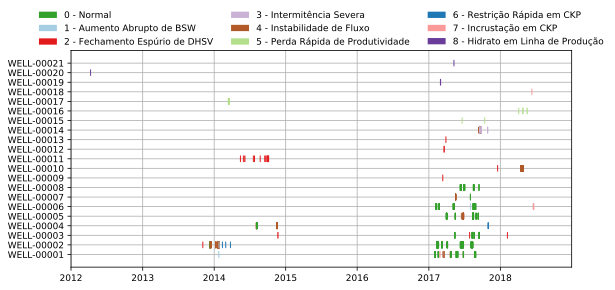

In [12]:
# Gera um gráfico com a localização no tempo de cada instância real por poço e por classe.
cmap = plt.get_cmap('Paired')
my_colors = [cmap(i) for i in [3, 0, 5, 8, 11, 2, 1, 4, 9, 7, 6, 10]]
my_cmap = mcolors.ListedColormap(my_colors, name='my_cmap')
plt.register_cmap(name='my_cmap', cmap=my_cmap)
cmap = plt.get_cmap('my_cmap')
height = 5
border = 2
first_year = np.min(df_time['min']).year
last_year = np.max(df_time['max']).year
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 9
fig, ax = plt.subplots(figsize=(9, 4))
yticks = []
yticks_labels = []
for well in well_times.keys():
    times = well_times[well]
    class_names = well_classes[well]    
    class_colors = list(map(cmap, class_names))
    well_id = well_code[well]
    yticks.append(well_id * height + height/2 - border/2)
    yticks_labels.append(well)
    ax.broken_barh(times, (well_id * height, height - border), facecolors=class_colors, edgecolors=class_colors)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(datetime(first_year, 1, 1).toordinal(), datetime(last_year, 12, 31).toordinal())
legend_colors = [Patch(facecolor=cmap(i), label=str(i) + ' - ' + events_name) for i, events_name in events_names.items()]
ax.legend(frameon=False, handles=legend_colors, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3);
#fig.savefig('figure.pdf', dpi=500, bbox_inches='tight')

# 5. Algumas estatísticas

Os principais aspectos do dataset relacionados às dificuldades inerentes aos dados reais são apresentados a seguir.

In [13]:
def calc_stats_instance(instance):
    """Função que carrega cada instância individualmente e analisa os dados
    para contagem de dados faltantes, congelados e não rotulados."""
    _, instance_path = instance
    n_vars_missing = 0
    n_vars_frozen = 0
    try:    
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        vars = df.columns[:-1]
        n_vars = len(vars)
        for var in vars:
            if df[var].isnull().all(): 
                n_vars_missing += 1
            u_values = df[var].unique()
            if len(u_values) == 1 and not np.isnan(u_values):
                n_vars_frozen += 1
        n_obs = len(df)
        n_obs_unlabeled = df['class'].isnull().sum()
        return pd.DataFrame({'n_vars':[n_vars], 
                             'n_vars_missing':[n_vars_missing],
                             'n_vars_frozen':[n_vars_frozen],
                             'n_obs':[n_obs],
                             'n_obs_unlabeled':[n_obs_unlabeled]
                            })
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')

In [14]:
def calc_stats_instances(instances):
    """Função que usa multiprocessing para calcular as estatísticas de diversas instâncias"""
    pool = ThreadPool()
    all_stats = []
    try:
        for stats in pool.imap_unordered(calc_stats_instance, instances):
            all_stats.append(stats)
    finally:
        pool.terminate()
    df_all_stats = pd.concat(all_stats)
    del all_stats
    return df_all_stats.sum()

In [15]:
global_stats = calc_stats_instances(real_instances+simulated_instances+drawn_instances)

In [16]:
print(f"Variáveis faltantes: {global_stats['n_vars_missing']} de {global_stats['n_vars']} ({100*global_stats['n_vars_missing']/global_stats['n_vars']:.2f}%)")
print(f"Variáveis congeladas: {global_stats['n_vars_frozen']} de {global_stats['n_vars']} ({100*global_stats['n_vars_frozen']/global_stats['n_vars']:.2f}%)")
print(f"Observações não rotuladas: {global_stats['n_obs_unlabeled']} de {global_stats['n_obs']} ({100*global_stats['n_obs_unlabeled']/global_stats['n_obs']:.2f}%)")

Variáveis faltantes: 4947 de 15872 (31.17%)
Variáveis congeladas: 1535 de 15872 (9.67%)
Observações não rotuladas: 5130 de 50913215 (0.01%)


# 6. Comentários

Ainda necessário ainda codificar os dados para separá-los e X (X_train e X_test) e y (y_train e y_test).

In [17]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 0:01:54.614342


# OUTROS

In [209]:
# Lista todas as instâncias de todas as classes
all_instances = list(class_and_file_generator(data_path, real=True, simulated=True, drawn=True))

Exemplo de instância da classe "Intermitência Severa"
Arquivo "data\3\WELL-00014_20170925110124.csv"


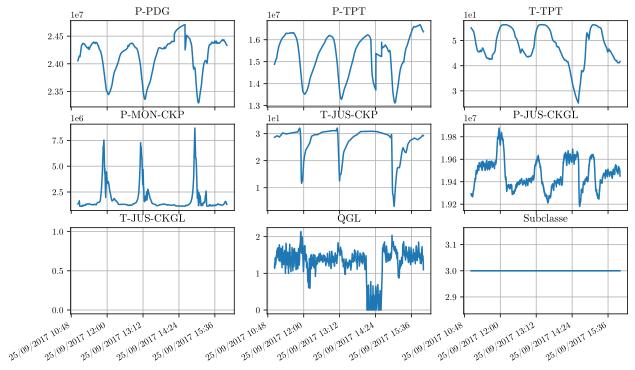

In [237]:
# Plotar uma instância aleatória
import random
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.ticker as ticker

# Define a fonte dos gráficos para a mesma do Latex
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'CMU Serif, Times New Roman'

# Sorteia e lê uma instância aleatória qualquer
instancia_sorteada = random.randint(0, len(all_instances))
df_all_instances = load_instance(all_instances[instancia_sorteada])


# Eixo x é o timestamp
x = df_all_instances.index

# Eixo y é o valor de cada uma das 9 variáveis
y1 = df_all_instances['P-PDG']
y2 = df_all_instances['P-TPT']
y3 = df_all_instances['T-TPT']
y4 = df_all_instances['P-MON-CKP']
y5 = df_all_instances['T-JUS-CKP']
y6 = df_all_instances['P-JUS-CKGL']
y7 = df_all_instances['T-JUS-CKGL']
y8 = df_all_instances['QGL']
y9 = df_all_instances['class']

# Monta uma gráfico com noves posições (3 x 3)
fig, axs = plt.subplots(3, 3, sharex=True)

# Seta algura e largura do gráfico
fig.set_figheight(6)
fig.set_figwidth(10)

# Plota os dados
axs[0, 0].plot(x, y1, 'tab:blue')
axs[0, 0].set_title('P-PDG')
axs[0, 1].plot(x, y2, 'tab:blue')
axs[0, 1].set_title('P-TPT')
axs[0, 2].plot(x, y3, 'tab:blue')
axs[0, 2].set_title('T-TPT')

axs[1, 0].plot(x, y4, 'tab:blue')
axs[1, 0].set_title('P-MON-CKP')
axs[1, 1].plot(x, y5, 'tab:blue')
axs[1, 1].set_title('T-JUS-CKP')
axs[1, 2].plot(x, y6, 'tab:blue')
axs[1, 2].set_title('P-JUS-CKGL')

axs[2, 0].plot(x, y7, 'tab:blue')
axs[2, 0].set_title('T-JUS-CKGL')
axs[2, 1].plot(x, y8, 'tab:blue')
axs[2, 1].set_title('QGL')
axs[2, 2].plot(x, y9, 'tab:blue')
axs[2, 2].set_title('Subclasse')

# Loop para ajustar os eixos.
for i, ax in enumerate(fig.axes):
    # format the ticks
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    # Grids
    ax.grid(True)
    # Escala cientifica no eixo y
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

print(f'Exemplo de instância da classe \"{events_names[all_instances[instancia_sorteada][0]]}\"')
print(f'Arquivo \"{all_instances[instancia_sorteada][1]}\"')

plt.show()